# David Viar

Los pasos que vamos a realizar son los siguientes:

1. Las funciones básicas pedidas por Idoven

    

*   Be able to read the ECG files and corresponding annotations
*   Show how they will work on the signal and plot the signal in appropriate manner to be read by a doctor

*   Identify the heart beat of the signal, average and total heart beat in the signal
*   Identify the complex QRS in the signal and been able to annotate on it

2. Clasificar señales de electro entre Myocardical infarction y paciente sano, desarrollando un método de clasíficación propio y tomando ventaja de las 15 derivaciones.







    
    
    

In [3]:
!wget https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip

--2022-09-08 08:35:39--  https://physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790456359 (1.7G) [application/zip]
Saving to: ‘ptb-diagnostic-ecg-database-1.0.0.zip’

ptb-diagnostic-ecg- 100%[===================>]   1.67G  6.61MB/s    in 3m 34s  

2022-09-08 08:39:14 (7.98 MB/s) - ‘ptb-diagnostic-ecg-database-1.0.0.zip’ saved [1790456359/1790456359]



Descomprimimos el zip

In [4]:
!unzip ptb-diagnostic-ecg-database-1.0.0.zip

Archive:  ptb-diagnostic-ecg-database-1.0.0.zip
 extracting: ptb-diagnostic-ecg-database-1.0.0/CONTROLS  
 extracting: ptb-diagnostic-ecg-database-1.0.0/SHA256SUMS.txt  
 extracting: ptb-diagnostic-ecg-database-1.0.0/RECORDS  
 extracting: ptb-diagnostic-ecg-database-1.0.0/ptb.png  
 extracting: ptb-diagnostic-ecg-database-1.0.0/README  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0417lre.dat  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0417lre.hea  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0373lre.dat  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0417lre.xyz  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0377lre.hea  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0369lre.dat  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0369lre.hea  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0377lre.xyz  
 extracting: ptb-diagnostic-ecg-database-1.0.0/patient095/s0377lre.dat  
 ex

Importamos las librerías necesarias con las que vamos a trabajar

Después de probar con pandas y numpy varias formas de leer los archivos, me dí cuenta que se planteaba dificil. Decidí (como se debería haber hecho desde el principio) leer la guia de la base de datos. Después de saltar por varias webs encontre el modulo wfdb.

In [1]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as ps

import wfdb
from wfdb import processing,plot


# 1. Leer, anotar y crear gráficas

In [7]:
record = wfdb.rdrecord("ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re")

Utilizamos el comando para obtener la señal almacenada en el objeto record

In [8]:
data = record.p_signal.T

Utilizamos el comando sig_name para obtener los nombres de las señales almacenadas en el objeto record

In [9]:
name = record.sig_name

El atributo fs nos da información de la frecuencia de muestreo de la señal

In [10]:
freq = record.fs

Comprobamos las unidades de las señales.

In [11]:
unit = record.units

Vamos a jugar con la señal, antes de crear el gráfico con las funciones de wfdb. Creamos el gráfico para una única derivación, ajustando el tiempo en segundos y la intensidad en mV. A partir de este generaremos un gráfico más realista con las 15 derivaciones.

In [12]:
num = 0 #cambiando el número podemos cambiar de derivación

ps.line(y=data[num],x=np.arange(0,38400)/freq, labels={'x':'t (s)', 'y':unit[num]},title="Signal Name " + name[num])

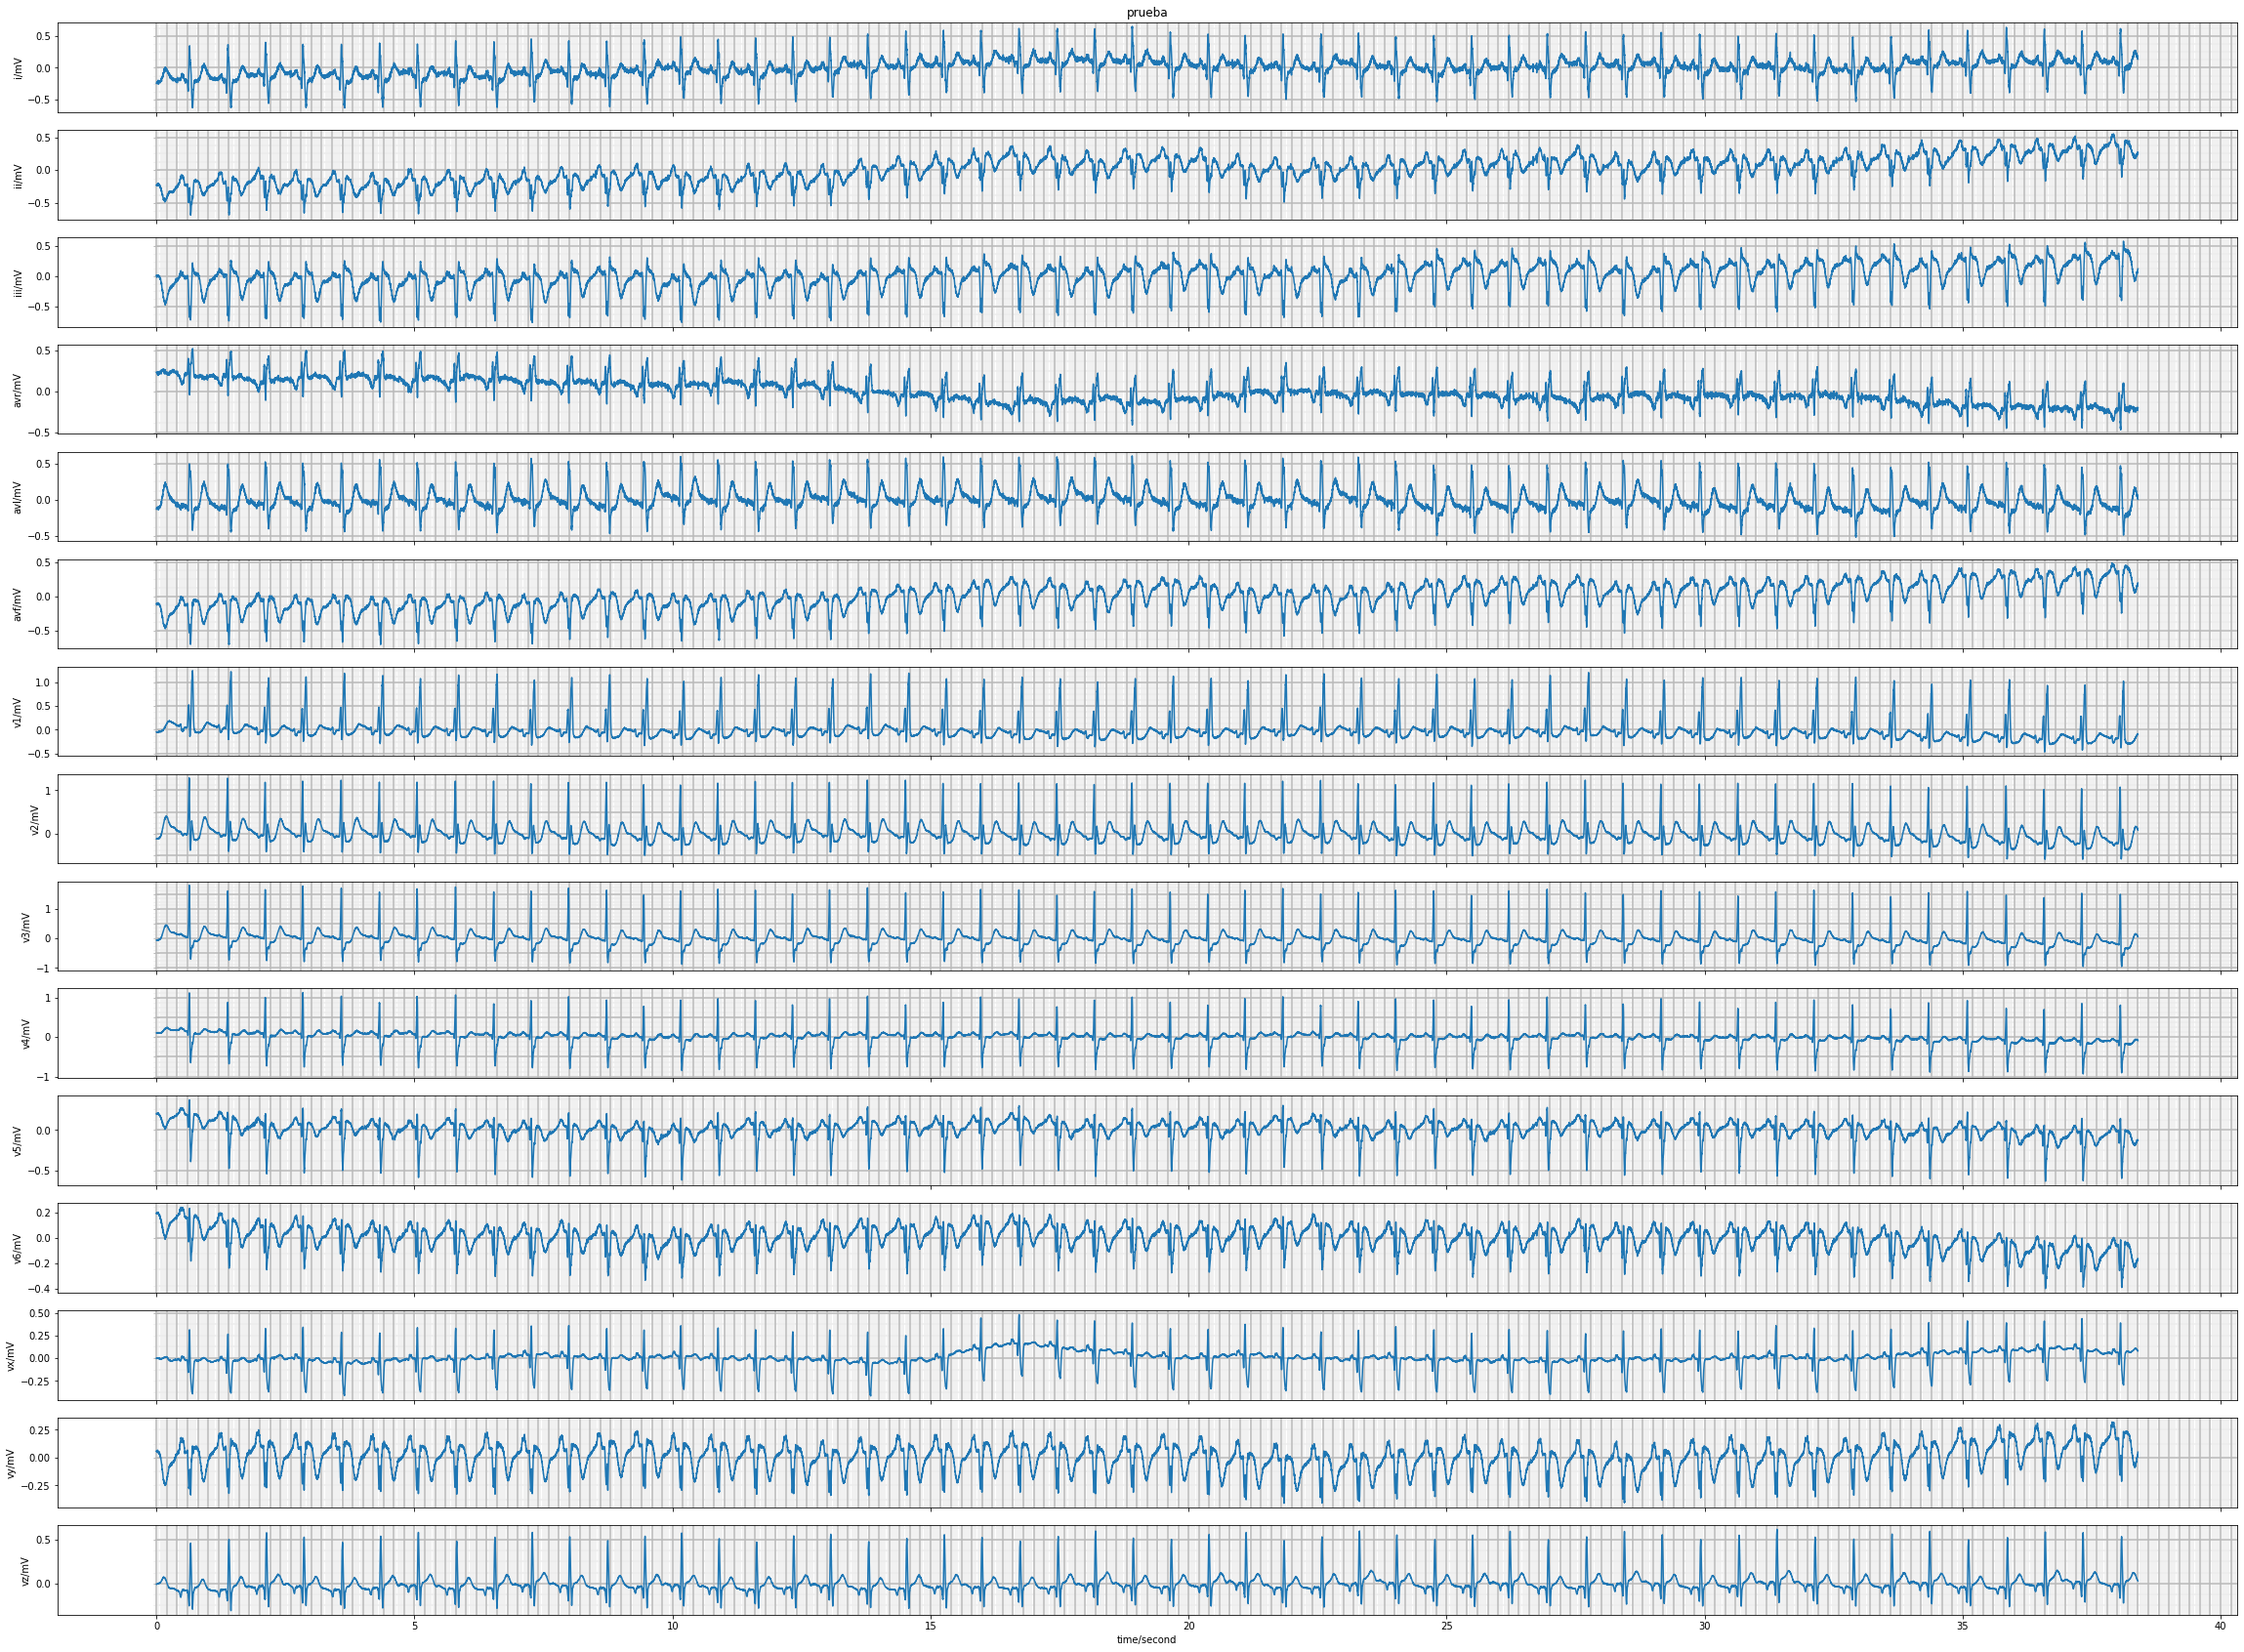

In [ ]:

wfdb.plot_wfdb(record,title="prueba",figsize=(40,30),ecg_grids="all")

Comprobamos que la función para generar electrocardiogramas funciona correctamente. Vemos varias partes a mejorar si un especialista quisiera darle  un uso convencional al programa: no es necesario obtener todo el rango de la señal y las últimas derivaciones no suelen usarse tanto si queremos obtener información básica. A modo de práctica vamos a coger una ventana dentro del electro y eliminar las tres últimas derivaciones

In [ ]:
brief_record = wfdb.rdrecord('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re',sampfrom=1000, sampto=6000,channel_names=['i',
 'ii',
 'iii',
 'avr',
 'avl',
 'avf',
 'v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6'])

brief_annotation = wfdb.rdann('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', 'xyz',sampfrom=1000 ,sampto=6000)

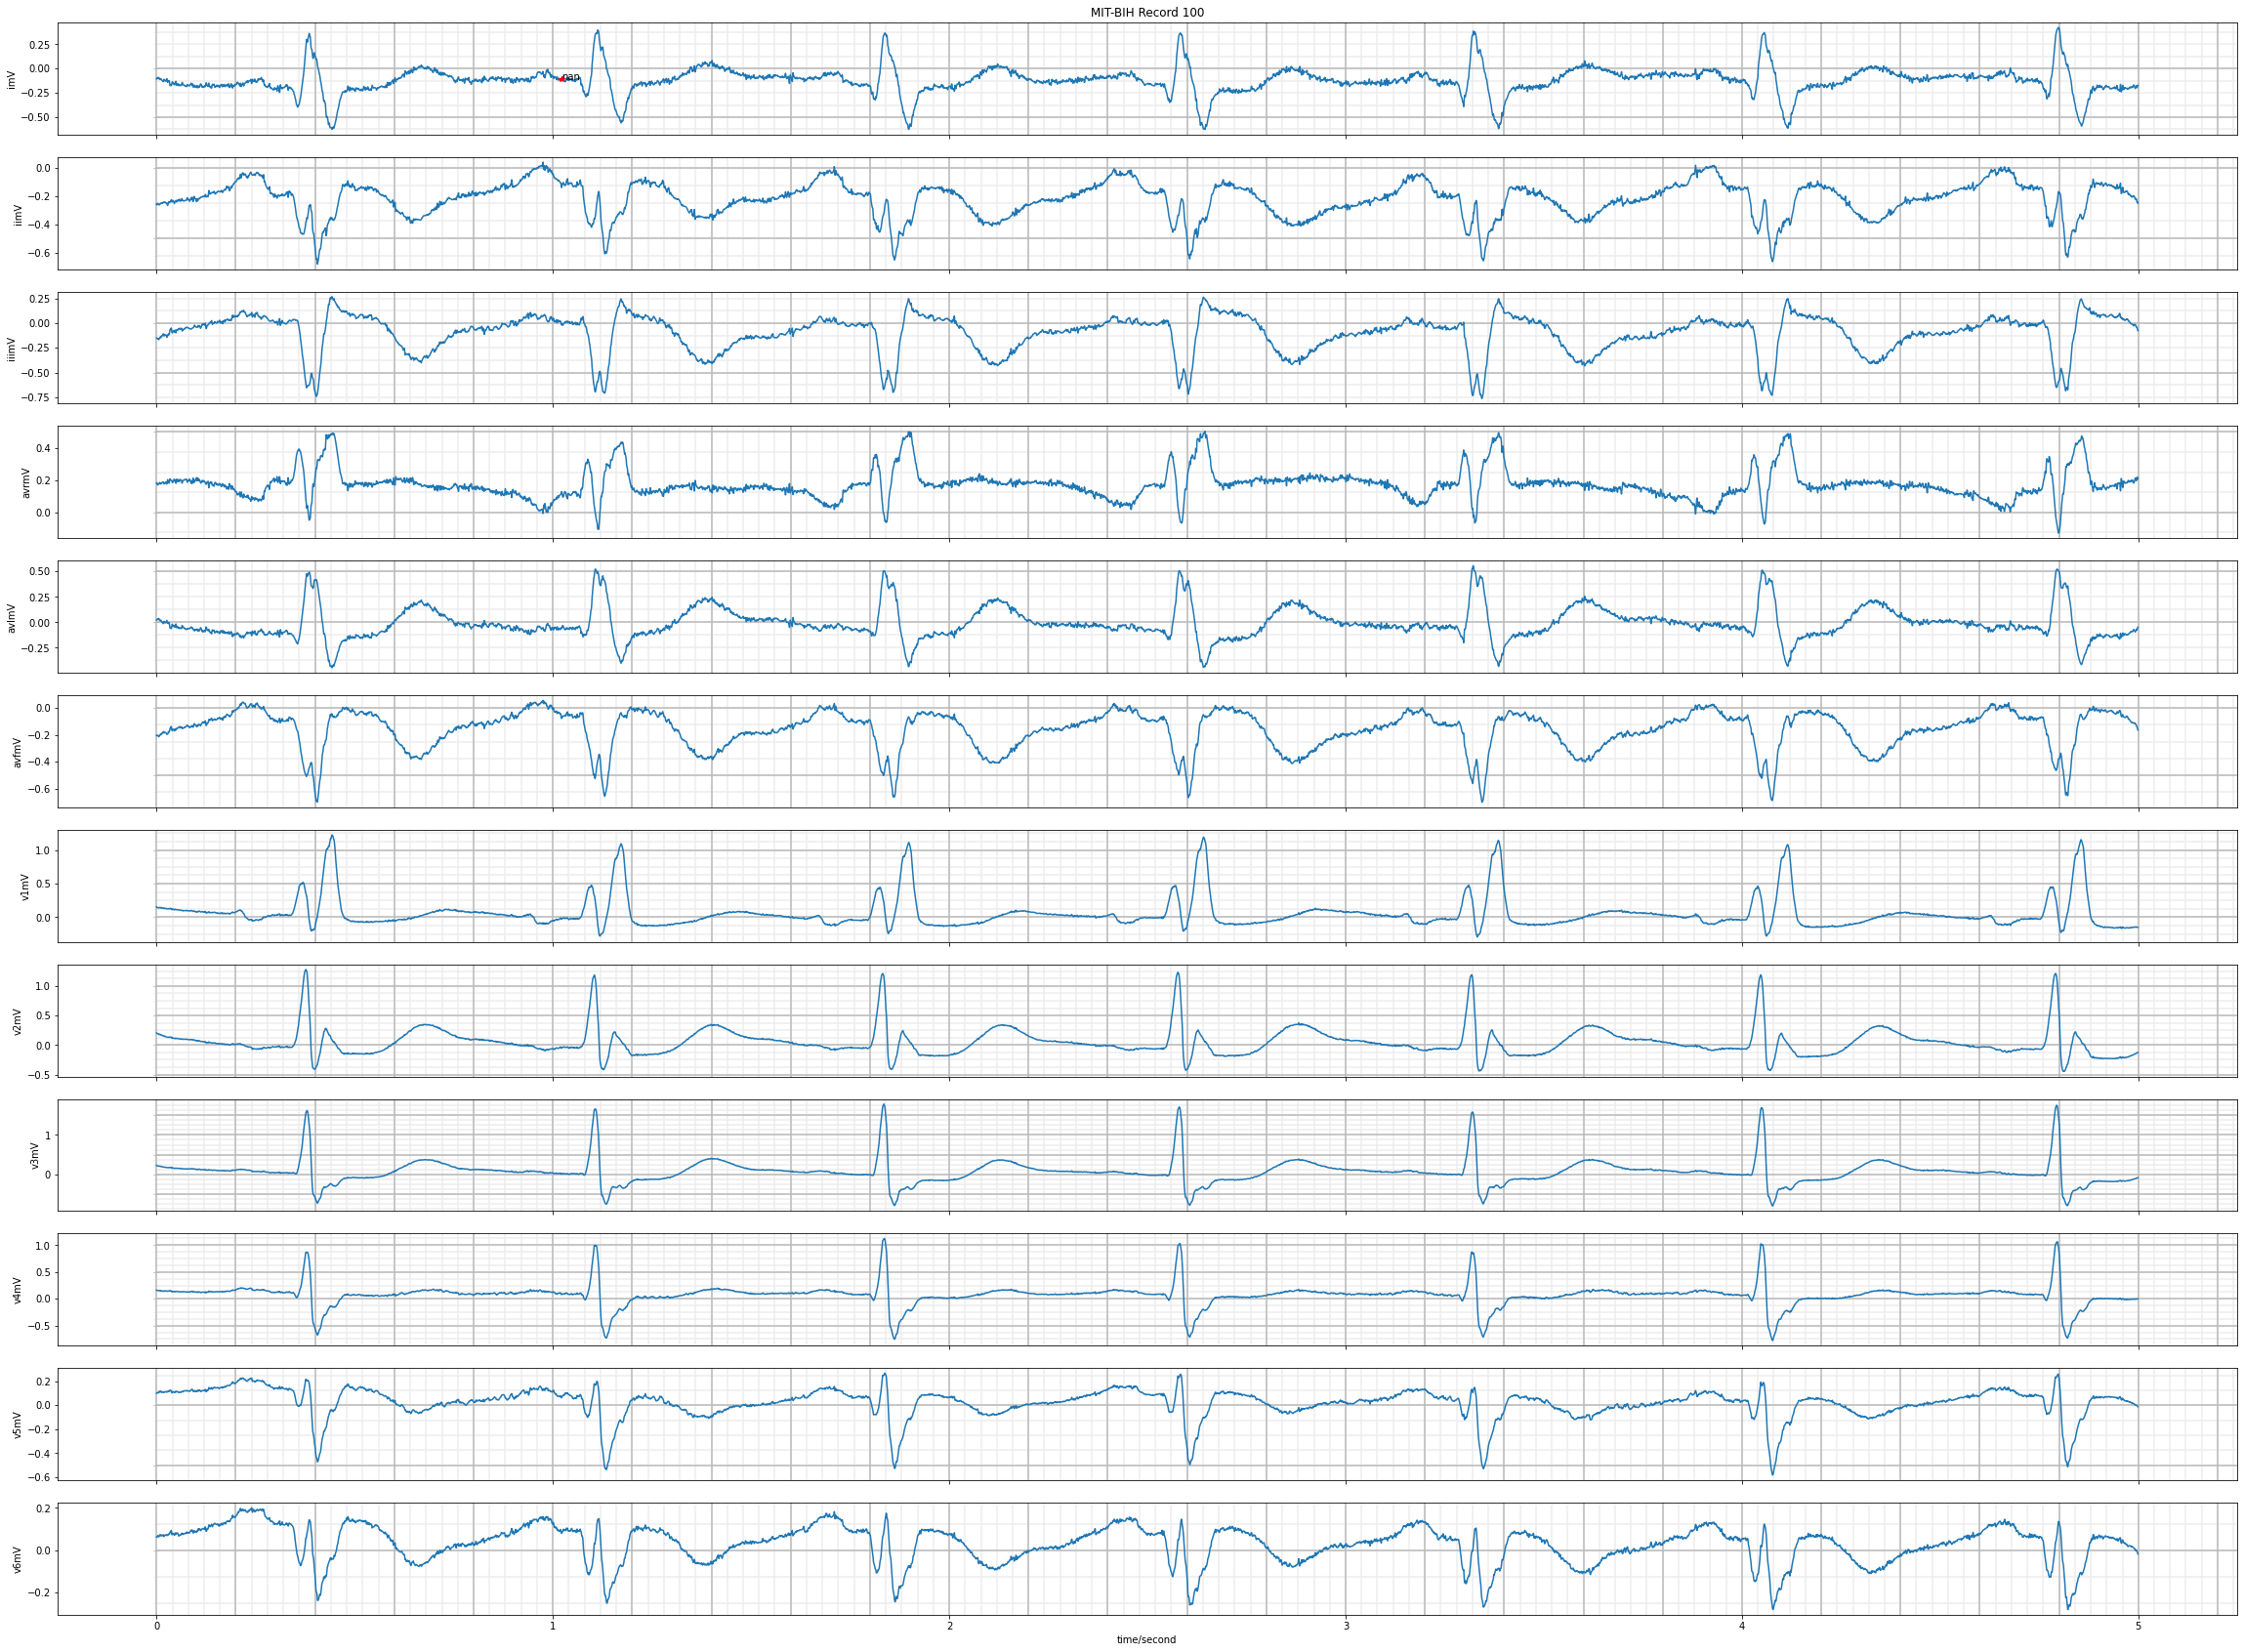

In [ ]:
wfdb.plot_wfdb(record=brief_record, annotation=brief_annotation, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(40,30), ecg_grids='all')

Si queremos detectar y medir la frecuencia cardiaca, hay variaos algoritmos publicados, muchos de ellos ya integrados en librerias  de programación para facilitar su uso. Yo he didido usar GQRS dentro de wfdb.

In [3]:
record_2 = wfdb.rdrecord('ptb-diagnostic-ecg-database-1.0.0/patient001/s0010_re', channels=[0], physical=False)

qrs_locs_2 = processing.gqrs_detect(d_sig=record_2.d_signal[:,0],
                                        fs=record_2.fs,
                                        adc_gain=record_2.adc_gain[0],
                                        adc_zero=record_2.adc_zero[0])

Una vez calculado el complejo QRS, es facil detectar la frecuencia cardiaca, debemos calcular el tiempo entre complejos. Aunque hay una función dedicada, la parte teórica sería saber cuanto tiempo ha pasado entre un complejo y otro (Q(t)-Q(t-1)) lo mismo para R o S.

In [4]:
intervals = processing.calc_rr(qrs_locs_2, fs=record_2.fs)
print(intervals)


[745 726 728 745 741 730 742 744 722 726 736 724 711 723 727 721 716 735
 740 728 727 740 739 723 730 740 730 716 735 737 726 723 739 733 724 739
 744 734 731 747 746 731 738 751 742 731 748 757 733 731 780]


Una vez calculados los intervalos entre complejos, lanzamos la función para calcular el ritmo cardiaco medio dentro del electro.

In [ ]:
hrm= processing.calc_mean_hr(intervals,fs=record_2.fs)

print("El ritmo cardiaco medio es de {} pulsaciones por minuto".format(hrm))

El ritmo cardiaco medio es de 81.69803764517421


Conociendo el complejo QRS es muy facil calcular cualquier otra propiedad relacionada con el ritmo cardiaco. En el siguiente ejemplo calculamos el ritmo cardiaco entre cada complejo.

In [ ]:

wfdb.processing.compute_hr(record_2.sig_len, qrs_locs_2, fs=record_2.fs)




array([      nan,       nan,       nan, ..., 82.079346, 82.079346,
       82.079346], dtype=float32)

Una vez conseguido el complejo qrs podemos guardarlo como anotación o bien crear una gráfica fusionando señal y anotación.

In [ ]:
processing.rr2ann(intervals,"ptb-diagnostic-ecg-database-1.0.0/patient001/anotation_rr_test","atr",record_2.fs)

Mostrar las anotaciones sobre el gráfico también es una buena práctica para comprobar que ha funcionado el algoritmo de detección de complejo QRS

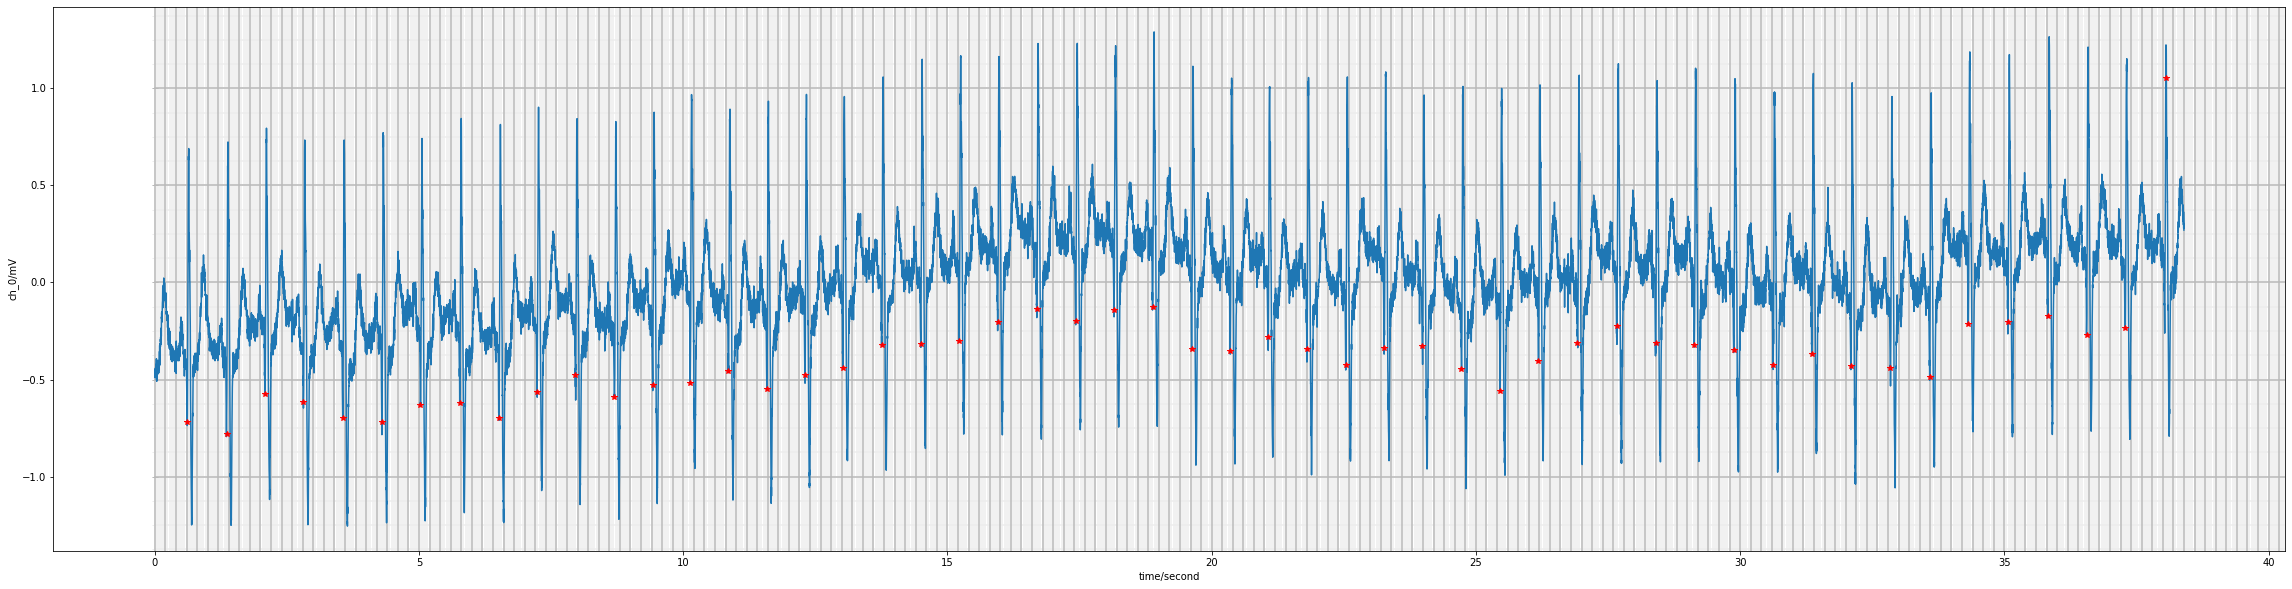

In [ ]:
plot.plot_items(record_2.d_signal/record_2.fs,[qrs_locs_2],figsize=(40,10),sig_units=record_2.units,ecg_grids=[0],fs=record_2.fs,time_units="seconds")

Creo que hay un fallo en la función anterior que no utiliza correctamente las unidades propuestas, provocando que aparezcan infinitas líneas (grid) en la gráfica. Para solucionarlo he divido la señal por 1000 para transformarla en mV, obteniendo un resultado positivo.

# 2. Parte de desarrollo libre.
Teniendo en cuenta que cada paciente cuenta con un electro de 15 derivaciones, se puede sacar partido  de esto y plantearlo como información 2D. Al final una señal 2D no deja de ser (en cierta medida) parecido a una imagen, por lo que podemos aplicar algoritmos de deep learning para resolver nuestro problema.

El objetivo es montar una red de clasificación que puede detectar de forma precisa entre pacientes con Myocardial infarction y pacientes sanos. La red que voy a implementar es muy simple para demostrar que es posible tratar una señal de ecg como una imagen. Esto se podria mejorar mucho más aplicando convoluciones y otro tipo de arquitecturas.

In [1]:
import scipy
import keras
import tensorflow as tf

Genero la base de datos, leyendo la información de cada paciente y guardando su ecg en una carpeta nombrada con la patología. 

In [ ]:
import glob
import os 
root = "ptb-diagnostic-ecg-database-1.0.0"
paths = glob.glob(root+"/patient*/*dat")
for path in paths:
  path_splited = path.split("/")
  patient_num = path_splited[1]
  file_name = path_splited[2]
  record = wfdb.rdrecord(path.split(".dat")[0])
  reason_admission = record.comments[4].split("Reason for admission: ")[1]
  if not os.path.exists(reason_admission):
    os.makedirs(reason_admission) 
  else:
    np.save(reason_admission+"/"+patient_num+"_"+file_name.split(".")[0]+".npy",record.p_signal.T[:,:32000])

In [4]:
signals=[]

for file in os.listdir("Myocardial infarction/"):
  signals.append(np.load("Myocardial infarction/"+file))

labels_infarction=np.ones(len(signals))

for file in os.listdir("Healthy control/"):
  signals.append(np.load("Healthy control/"+file))

labels_controls=np.ones(len(signals)-labels_infarction.shape[0])*0

labels = np.append(labels_infarction,labels_controls)
signals = np.dstack(signals)
signals = np.rollaxis(signals,-1)
print(signals.shape,labels.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((signals, labels))



(448, 15, 32000) (448,)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((signals, labels))


Ahora devemos tomar una parte para validation, train y test. Para ello utilizo una función ya implementada en tf

In [5]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

Aleatorizo el dataset y creo el batch de entrenamiento

In [14]:
 train_ds, val_ds, test_ds=get_dataset_partitions_tf(train_dataset,labels.shape[0])

In [18]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 100

val_ds = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = 100

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = 100

test_ds = test_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [49]:
print(train_ds, val_ds,test_ds)

<TakeDataset element_spec=(TensorSpec(shape=(None, 15, 32000), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))> <TakeDataset element_spec=(TensorSpec(shape=(None, 15, 32000), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))> <SkipDataset element_spec=(TensorSpec(shape=(None, 15, 32000), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


Genero una red densamente conexa muy sencilla para clasificar

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(15, 32000)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


Entrenamos la red con el dataset generado

In [20]:
history = model.fit(train_ds,validation_data=val_ds, batch_size=20, epochs=10)

Epoch 1/10
36/36 [==============================] - 20s 543ms/step - loss: 144.9640 - accuracy: 0.6704 - val_loss: 116.0915 - val_accuracy: 0.7500
Epoch 2/10
36/36 [==============================] - 23s 642ms/step - loss: 79.8079 - accuracy: 0.7905 - val_loss: 7.4374 - val_accuracy: 0.8636
Epoch 3/10
36/36 [==============================] - 20s 570ms/step - loss: 88.3866 - accuracy: 0.7737 - val_loss: 3.5620 - val_accuracy: 0.9318
Epoch 4/10
36/36 [==============================] - 19s 526ms/step - loss: 46.3062 - accuracy: 0.7793 - val_loss: 26.8129 - val_accuracy: 0.8636
Epoch 5/10
36/36 [==============================] - 20s 539ms/step - loss: 51.3044 - accuracy: 0.8324 - val_loss: 6.7381 - val_accuracy: 0.8182
Epoch 6/10
36/36 [==============================] - 19s 530ms/step - loss: 25.6051 - accuracy: 0.8547 - val_loss: 9.8045 - val_accuracy: 0.8636
Epoch 7/10
36/36 [==============================] - 19s 526ms/step - loss: 36.1989 - accuracy: 0.8687 - val_loss: 0.2406 - val_accur

In [23]:
model.evaluate(test_ds)


46/46 [==============================] - 3s 34ms/step - loss: 7.5450 - accuracy: 0.9130


[7.545016288757324, 0.9130434989929199]

## Los resultados finales para el conjunto de test (46 ecgs) son un 91.30% de accuracy y una perdida de 7.54.

Estos resultados se pueden mejorar en gran medida aplicando redes convolucionales e incluso añadiendo capas densas a la arquictura original.

Esto demuestra que los algoritmos de Deep Learning pueden ser usados en clasificación de ecg.


# ¿Cómo pienso que se podría mejorar?

El ejemplo anterior es solo una idea de lo que podría ofrecer a Idoven como Data Scientist. A continuación, propongo mejoras que podrían hacerse al problema de clasificación. 

Añado que al igual que hemos clasificado entre pacientes sanos y con Myocardial infarction, también se podrían añadir el resto de clases por las que un paciente es ingresado (Palpitation, Myocarditis...).

El bonito mundo de las convoluciones. Se ha demostrado en varios artículos que en muchos casos (donde hay información espacial sobre todo) mejoran al comportamiento de las redes densas (el ejemplo anterior) y necesitan menor computo.

Teniendo esto en cuenta es dificil aplicar convoluciones a un ecg de la forma que se presentaba anterior mente (una matriz de 15X32000). Para concentrar la información podemos usar un espectrograma que através de diferentes  transformaciones en frecuencia con la señal, se obtine una imagen.

In [16]:
_,_,a=scipy.signal.spectrogram(record_2.d_signal.T,fs=record_2.fs)

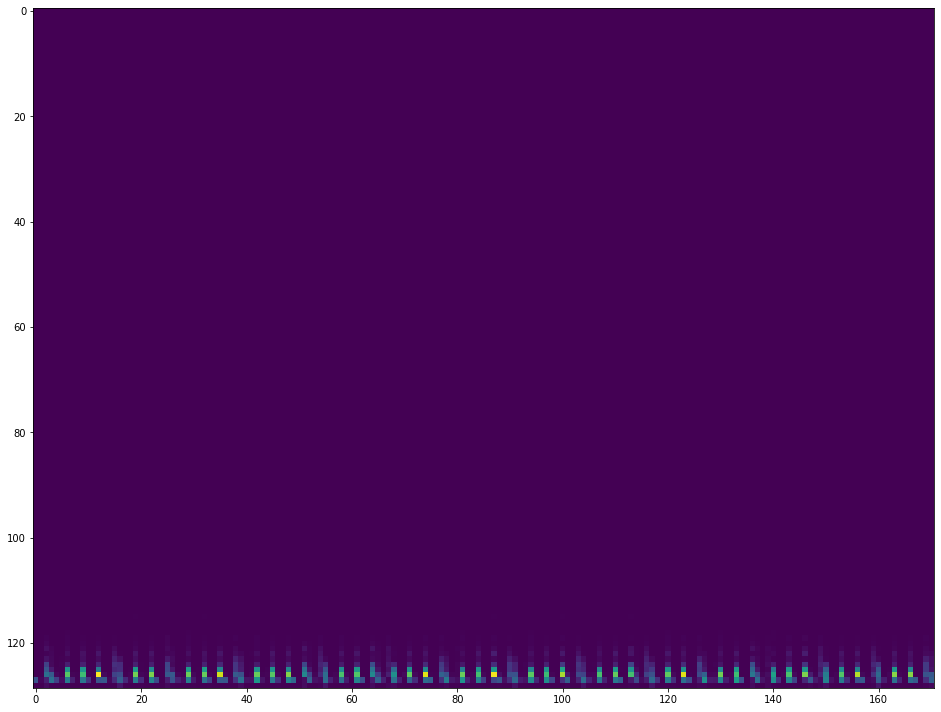

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(a[0][::-1,:])
plt.tight_layout()

Una vez obtenida esta imagen, podemos aplicar un logaritmo para potenciar las partes con información. De igual manera, una vez concentrada la información podemos aplicar convoluciones 2D y volver a montar una red de clasificación, añadiendo si quisieramos el resto de etiquetas.

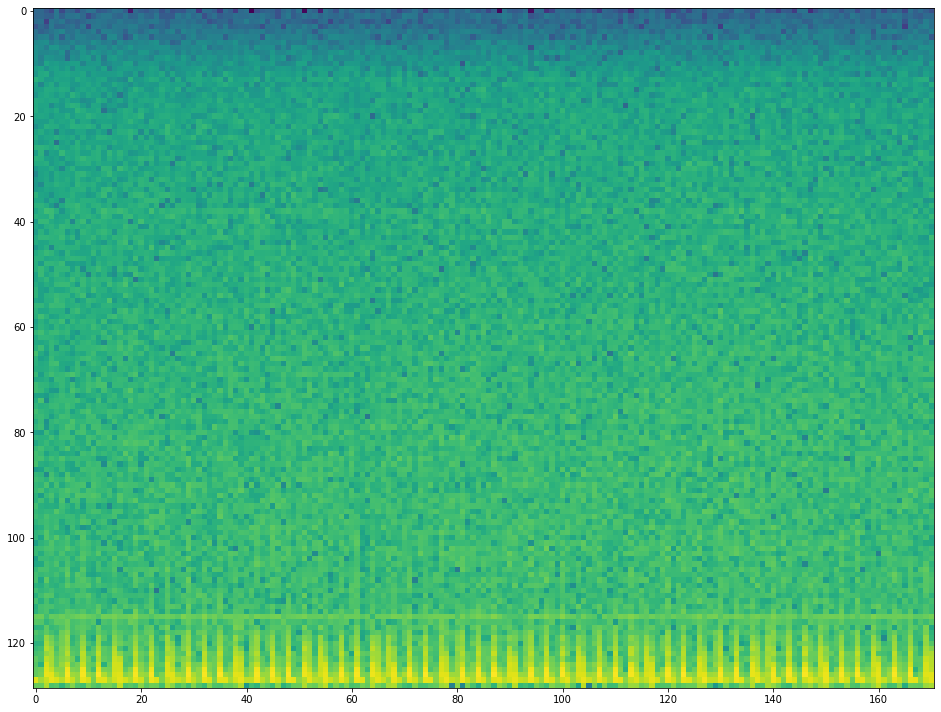

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(np.log(a[0])[::-1,:])
plt.tight_layout()

#Con este notebook pretendo mostrar que un perfil más destinado a Computer Vision es de gran ayuda para afrontar nuevos retos y resolver los existentes desde otros puntos de vista. 

## Para el problema propuesto de clasificación, dedicando más tiempo y montando redes más complejas podríamos obtener unos resultados sorpredentes.

#Muchas gracias por la oportunidad